# Q3 Using Scikit-Learn

# Imports
Do not modify

In [2]:
#export
import pkg_resources
from pkg_resources import DistributionNotFound, VersionConflict
from platform import python_version
import numpy as np
import pandas as pd
import time
import gc
import random
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [3]:
%load_ext autoreload
%autoreload 2
import tests as tests

# Verify your Python version and setup

In [4]:
# Define some functions to check setup
def check_python_version():
    print('Your python version is ', python_version())
    assert python_version()[:3] == '3.7', 'Make sure you use python version >=3.7'

def check_env_setup():
    dependencies = open("requirements.txt").readlines()
    try:
        pkg_resources.require(dependencies)
        print("✅ ALL GOOD")
    except DistributionNotFound as e:
        print("⚠️ Library is missing")
        print(e)
    except VersionConflict as e:
        print("⚠️ Library version conflict")
        print(e)
    except Exception as e:
        print("⚠️ Something went wrong")
        print(e)

In [5]:
# verify the environment setup
check_python_version()
check_env_setup()

Your python version is  3.7.12
⚠️ Library version conflict
(jupyter-core 4.11.1 (c:\users\sande\anaconda3\envs\py37\lib\site-packages), Requirement.parse('jupyter-core!=5.0.*,>=4.12'), {'jupyter-console'})


In [6]:
raw_df = pd.read_csv('final_output.csv')

In [7]:
raw_df['Date'] = pd.to_datetime(raw_df['Date'])

In [8]:
df1 = raw_df['S&P 500']
df1.shape

(8401,)

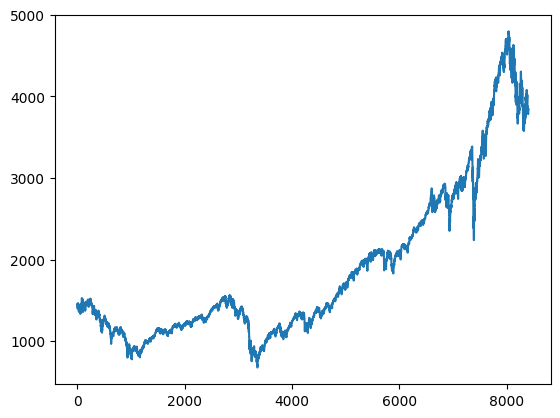

In [9]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df2

array([[0.18900105],
       [0.18900105],
       [0.18900105],
       ...,
       [0.77007934],
       [0.76770557],
       [0.76770557]])

In [12]:
train_size = int(len(df2)*.7)
test_size = len(df2) - train_size
train_data, test_data = df2[0:train_size,:],df2[train_size:len(df2),:]

In [13]:
def create_lstm_ds(dataset,time_step=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        dataX.append(dataset[i:(i+time_step),0])
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [14]:
time_step = 360
X_train, y_train = create_lstm_ds(train_data,time_step)
X_test, y_test = create_lstm_ds(test_data,time_step)

In [61]:
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((5519, 360), (0,), (2160, 360), (2160,))

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(360,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 360, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 360, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=30, batch_size=64,verbose=1)

Epoch 1/30
87/87 [==============================] - 141s 1s/step - loss: 0.0013 - val_loss: 6.5911e-04
Epoch 2/30
87/87 [==============================] - 126s 1s/step - loss: 5.9045e-05 - val_loss: 0.0013
Epoch 3/30
87/87 [==============================] - 121s 1s/step - loss: 5.9942e-05 - val_loss: 0.0011
Epoch 4/30
87/87 [==============================] - 105s 1s/step - loss: 5.6522e-05 - val_loss: 0.0010
Epoch 5/30
87/87 [==============================] - 121s 1s/step - loss: 5.4957e-05 - val_loss: 0.0016
Epoch 6/30
87/87 [==============================] - 126s 1s/step - loss: 5.4588e-05 - val_loss: 7.2213e-04
Epoch 7/30
87/87 [==============================] - 122s 1s/step - loss: 5.1108e-05 - val_loss: 6.1536e-04
Epoch 8/30
87/87 [==============================] - 120s 1s/step - loss: 5.4046e-05 - val_loss: 4.2995e-04
Epoch 9/30
87/87 [==============================] - 127s 1s/step - loss: 5.2004e-05 - val_loss: 5.7001e-04
Epoch 10/30
87/87 [==============================] - 126s

In [66]:
train_predict = scaler.inverse_transform(model.predict(X_train))
test_predict = scaler.inverse_transform(model.predict(X_test))


68/68 [==============================] - 11s 166ms/step


In [67]:
test_predict

array([[2283.8694],
       [2282.2134],
       [2279.847 ],
       ...,
       [3769.6003],
       [3766.1775],
       [3765.3103]], dtype=float32)

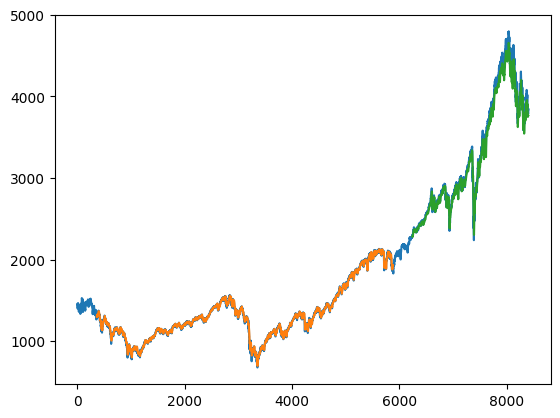

In [68]:
look_back = 360
trainPrPlot = np.empty((8401,1,))
trainPrPlot[:, :] = np.nan
trainPrPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPrPlot = np.empty((8401,1,))
testPrPlot[:, :] = np.nan
testPrPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
plt.plot(df1)
plt.plot(trainPrPlot)
plt.plot(testPrPlot)
plt.show()

In [69]:
x_input=test_data[2161:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [70]:
lst_output=[]
n_steps=360
i=0
while(i<360):
    
    if(len(temp_input)>360):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

In [71]:
future_predict_360 = scaler.inverse_transform(lst_output)

C:\Users\sande\anaconda3\envs\py37\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


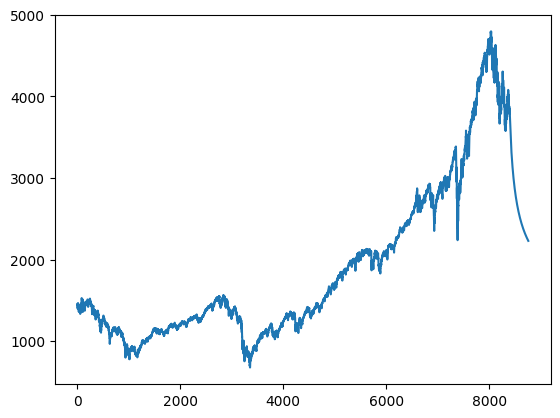

In [72]:
df3=df1.tolist()
df3.extend(future_predict_360)
plt.plot(df3[:])

In [47]:
pd.DataFrame(train_predict).to_csv("train-predicted.csv", encoding='utf-8', index=False)

In [50]:
pd.DataFrame(future_predict_360).to_csv("future360-predicted.csv", encoding='utf-8', index=False)

In [49]:
pd.DataFrame(test_predict).to_csv("test-predicted.csv", encoding='utf-8', index=False)